# Data collection and preprocessing

---





## Installs

In [39]:
!pip install noisereduce

## Imports

In [40]:
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
from librosa.util import normalize
import noisereduce as nr
import seaborn as sns
from google.colab import drive
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from IPython.display import Javascript, Audio
from google.colab import output
from base64 import b64decode
import warnings

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters


In [41]:
fs = 44100           # Sampling rate
top_db = 20          # Silence threshold in decibels

# Mel's spectrogram parameters
n_fft_parameter = int(0.025 * fs)
hop_length_parameter = int(n_fft_parameter/2)
n_mels_parameter = 40

## Audio signal reading, preprocessing and feature extraction function

In [67]:
carpetasAudios = os.listdir('/content/drive/MyDrive/SEÑALES/Audios Señales')
carpetasAudios.sort()
dataset=[]

for label, audioBruto in enumerate(carpetasAudios):
  for fileName in glob.glob(os.path.join('/content/drive/MyDrive/SEÑALES/Audios Señales', audioBruto, '*.wav')):
    try:
      signal, sr = librosa.load(fileName, mono=True, sr=fs)
      trimmed_signal = librosa.effects.trim(signal, top_db= 20)
      reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
      normalized_signal = librosa.util.normalize(reduced_noise_signal)

      melspec = librosa.feature.melspectrogram(y=normalized_signal, sr=fs, power=2, n_mels=n_mels_parameter, center=False, hop_length=hop_length_parameter, n_fft=n_fft_parameter)
      melspecM = np.mean(melspec.T, axis=0)

      mfcc = librosa.feature.mfcc(y=normalized_signal, n_mfcc=13)
      mfccM = np.mean(mfcc.T, axis=0)
      delta_mfcc = librosa.feature.delta(mfccM)
      delta2_mfcc = librosa.feature.delta(mfccM, order=2)

      chroma = librosa.feature.chroma_stft(y=normalized_signal, sr=fs)
      chromaM = np.mean(chroma.T, axis=0)

      tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(normalized_signal), sr=fs)
      tonnetM = np.mean(tonnetz.T,axis=0)

      signal_features = np.hstack((mfccM, delta_mfcc, delta2_mfcc, melspecM, chromaM, tonnetM))

      dataset.append([signal_features, label])

    except Exception as e:
      print(f'Error: {e}')
      continue

print('Feature extraction completed')

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

Feature extraction completed


# Dataset

---



## Partitioning



In [43]:
featureDf = pd.DataFrame(dataset, columns=['FEATURES', 'LABEL'])
x = np.array(featureDf.FEATURES.tolist())
y = np.array(featureDf.LABEL.tolist())
y = y.reshape((y.shape[0],-1))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10, stratify=y)
batch_size = len(x_train)

print(y.shape)
print(x_train.shape, y_train.shape, y_test.shape )

(665, 1)
(532, 97) (532, 1) (133, 1)


## Dataset visualization




In [44]:
feature_array = np.array(featureDf['FEATURES'].tolist())
new_feature_df = pd.DataFrame(feature_array.tolist(), columns=[f'FEATURE_{i+1}' for i in range(97)])
featureDf = pd.concat([new_feature_df, featureDf['LABEL']], axis=1)

featureDf.info()
total = featureDf.isnull().sum().sort_values(ascending=False)
percent_1 = featureDf.isnull().sum()/featureDf.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(featureDf.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 98 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FEATURE_1   665 non-null    float64
 1   FEATURE_2   665 non-null    float64
 2   FEATURE_3   665 non-null    float64
 3   FEATURE_4   665 non-null    float64
 4   FEATURE_5   665 non-null    float64
 5   FEATURE_6   665 non-null    float64
 6   FEATURE_7   665 non-null    float64
 7   FEATURE_8   665 non-null    float64
 8   FEATURE_9   665 non-null    float64
 9   FEATURE_10  665 non-null    float64
 10  FEATURE_11  665 non-null    float64
 11  FEATURE_12  665 non-null    float64
 12  FEATURE_13  665 non-null    float64
 13  FEATURE_14  665 non-null    float64
 14  FEATURE_15  665 non-null    float64
 15  FEATURE_16  665 non-null    float64
 16  FEATURE_17  665 non-null    float64
 17  FEATURE_18  665 non-null    float64
 18  FEATURE_19  665 non-null    float64
 19  FEATURE_20  665 non-null    f

Total    %
FEATURE_1       0  0.0
FEATURE_74      0  0.0
FEATURE_72      0  0.0
FEATURE_71      0  0.0
FEATURE_70      0  0.0
...           ...  ...
FEATURE_31      0  0.0
FEATURE_30      0  0.0
FEATURE_29      0  0.0
FEATURE_28      0  0.0
LABEL           0  0.0

[98 rows x 2 columns]

In [45]:
featureDf.head()

FEATURE_1   FEATURE_2  FEATURE_3  FEATURE_4  FEATURE_5  FEATURE_6  \
0 -281.029968  106.826424   2.219350   8.157929  15.693202  41.867134   
1 -327.453461  125.951897 -31.988247  28.286154  13.767224  24.269527   
2 -335.521149  157.864380  11.302232  36.697441   7.183962  13.128595   
3 -277.380707  126.446373  32.002567   4.996969  38.746334  38.732849   
4 -284.124908   99.699173  39.521145  20.241024  26.159698  42.191418   

   FEATURE_7  FEATURE_8  FEATURE_9  FEATURE_10  ...  FEATURE_89  FEATURE_90  \
0  -8.136936  20.805210  -6.791693    7.298568  ...    0.349214    0.582686   
1  21.481466 -19.414845   2.594694   -0.995257  ...    0.338973    0.237120   
2   8.171672 -11.806852  18.829941   -3.834847  ...    0.555022    0.539077   
3  -0.670958   6.168674   5.121574   11.546824  ...    0.481566    0.461704   
4  21.503105   8.807985  18.264635    8.599735  ...    0.518537    0.557746   

   FEATURE_91  FEATURE_92  FEATURE_93  FEATURE_94  FEATURE_95  FEATURE_96  \
0    0.585842    0.030232    0.058328    0.009378    0.080859    0.007108   
1    0.241514   -0.063565    0.090648    0.057708    0.062829   -0.035636   
2    0.453187   -0.048550   -0.014900   -0.046472    0.064968   -0.022534   
3    0.425411   -0.007582    0.025708   -0.085288   -0.070049    0.029844   
4    0.614332    0.032575   -0.033191    0.032541    0.068368   -0.021920   

   FEATURE_97  LABEL  
0    0.048180      0  
1   -0.046409      0  
2   -0.015595      0  
3   -0.011358      0  
4    0.020361      0  

[5 rows x 98 columns]

In [46]:
featureDf.describe()

FEATURE_1   FEATURE_2   FEATURE_3   FEATURE_4   FEATURE_5   FEATURE_6  \
count  665.000000  665.000000  665.000000  665.000000  665.000000  665.000000   
mean  -346.266529   96.719639   18.554405   22.628507   23.631824   17.410902   
std     67.514331   32.424090   19.030056   12.755961   11.819787   13.944324   
min   -507.765228   17.460032  -57.642582  -27.976442  -24.477695  -25.807259   
25%   -396.942078   74.121811    7.431372   14.261101   16.716948    8.912683   
50%   -356.554443   92.846428   18.723585   22.527609   24.044353   17.505051   
75%   -296.986145  112.727386   31.205431   31.083279   30.453695   26.447620   
max   -166.185577  223.773193   79.644676   64.744576   62.693081   59.747440   

        FEATURE_7   FEATURE_8   FEATURE_9  FEATURE_10  ...  FEATURE_89  \
count  665.000000  665.000000  665.000000  665.000000  ...  665.000000   
mean    12.882518    4.212393   10.121868    9.248192  ...    0.459735   
std     10.812481   10.728076    9.443525   10.434748  ...    0.125974   
min    -39.948254  -33.918640  -16.987001  -24.409992  ...    0.144770   
25%      6.493976   -2.574649    3.676963    2.454253  ...    0.374155   
50%     12.996174    5.255992   10.809656    9.403955  ...    0.458507   
75%     20.028328   11.509342   16.770500   15.783540  ...    0.543136   
max     49.403145   37.755608   40.016445   43.553856  ...    0.840195   

       FEATURE_90  FEATURE_91  FEATURE_92  FEATURE_93  FEATURE_94  FEATURE_95  \
count  665.000000  665.000000  665.000000  665.000000  665.000000  665.000000   
mean     0.457318    0.447918   -0.002739   -0.000417   -0.000669   -0.004439   
std      0.122994    0.125308    0.044701    0.048005    0.077628    0.085326   
min      0.106894    0.058813   -0.188340   -0.348436   -0.382112   -0.482569   
25%      0.377257    0.363681   -0.027047   -0.026095   -0.042371   -0.047493   
50%      0.459252    0.453187   -0.002199    0.000295    0.001672   -0.005981   
75%      0.539812    0.532517    0.022033    0.022968    0.047105    0.042739   
max      0.775267    0.783938    0.195898    0.193232    0.312309    0.301532   

       FEATURE_96  FEATURE_97       LABEL  
count  665.000000  665.000000  665.000000  
mean    -0.000776   -0.000986    2.000000  
std      0.025504    0.028179    1.415278  
min     -0.108858   -0.115660    0.000000  
25%     -0.016046   -0.015697    1.000000  
50%     -0.000079   -0.002940    2.000000  
75%      0.014225    0.012966    3.000000  
max      0.115792    0.187210    4.000000  

[8 rows x 98 columns]

## Correlation matrix

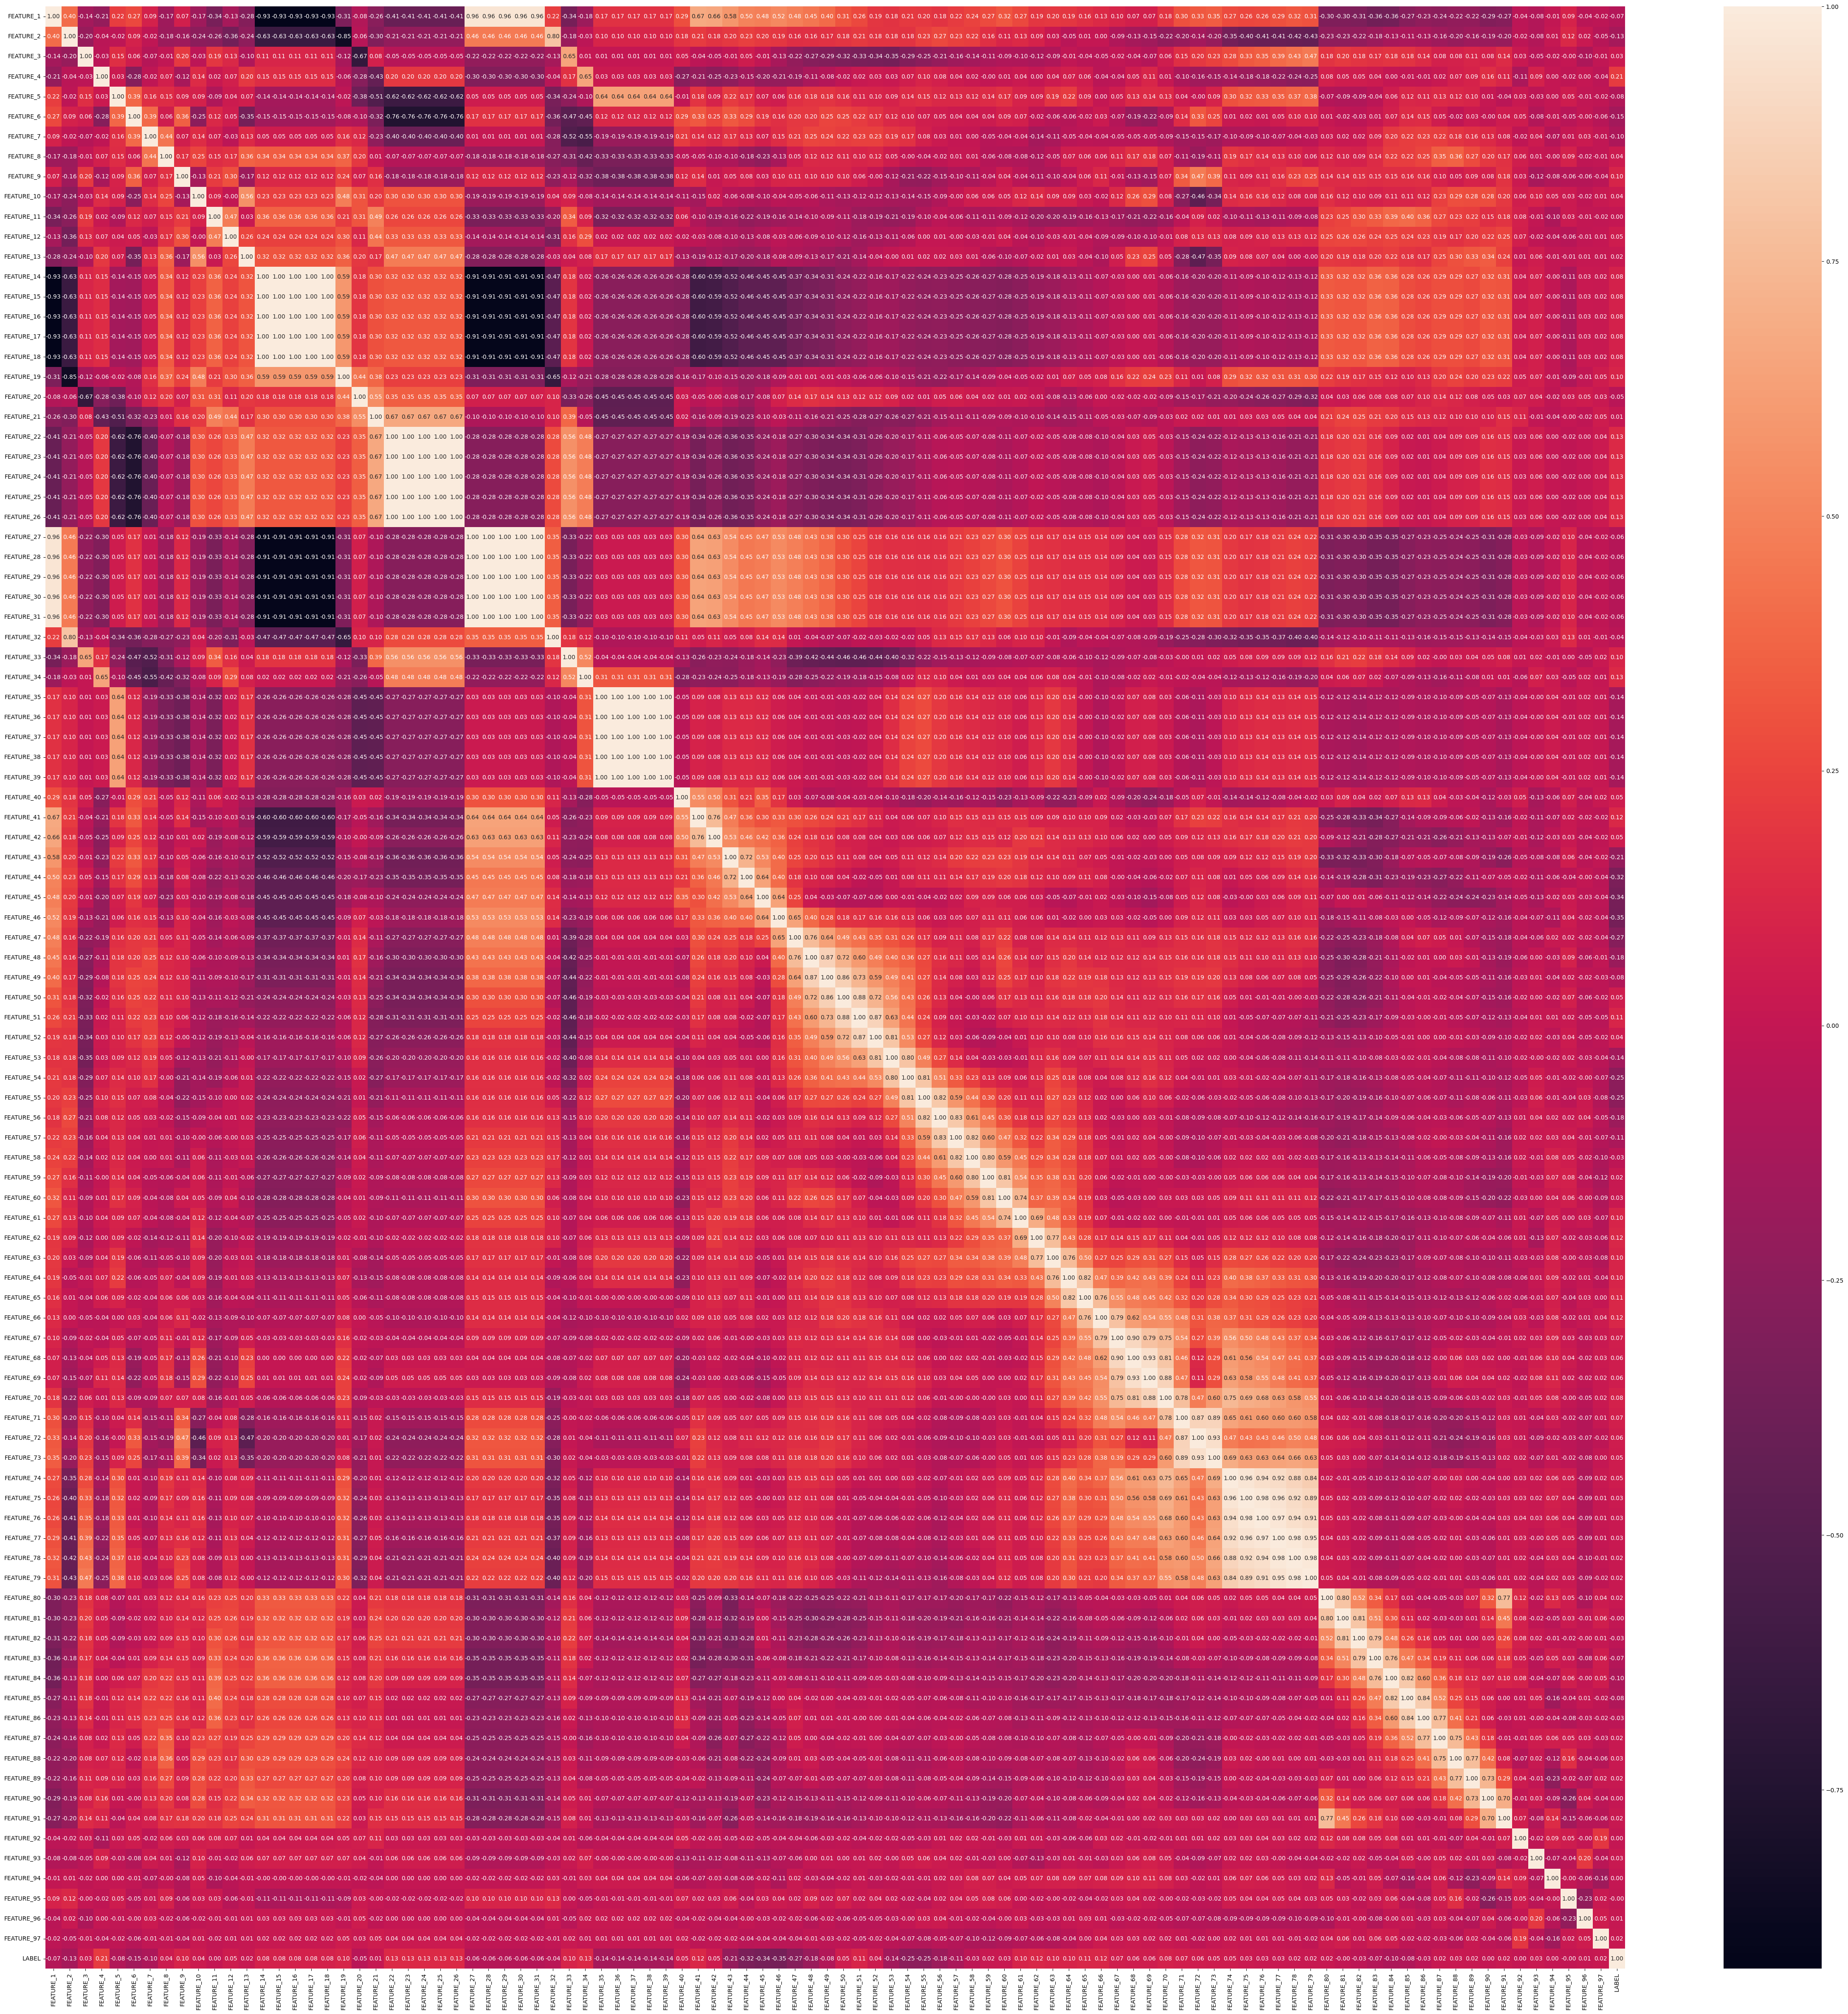

In [47]:
fig, ax = plt.subplots(figsize=(60, 60))
correlacion_n = featureDf.corr(method="spearman")
sns.heatmap(correlacion_n,annot=True, fmt=".2f")
plt.show()

# Model

---



In [48]:
# Defining hyperparameters and possible values for Grid Search
param_grid = {
    'n_estimators': [300, 320, 340, 360, 380],
    'criterion': ['gini'],
    'max_features': ['sqrt'],
    'random_state': [15, 30, 45]
}

clf = RandomForestClassifier()

# Perform Grid Search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy')
grid_search.fit(x_train, y_train.ravel())

# Obtain the best hyperparameters found
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Training the classifier with the best hyperparameters
clf = RandomForestClassifier(**best_params)
clf.fit(x_train, y_train.ravel())

# Evaluating the classifier on test data
score = clf.score(x_test, y_test)
print("Accuracy: {:.2f}".format(score))

y_pred = clf.predict(x_test)
precision = precision_score(y_test, y_pred, average='micro')
print("Precision: {:.2f}".format(precision))

Best hyperparameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 360, 'random_state': 15}
Accuracy: 0.81
Precision: 0.81


# Performance measurement

---





In [49]:
predictions = y_pred
print(y_test[:].ravel())
print(predictions[:])

[2 4 2 1 3 4 3 4 1 4 3 4 2 0 3 2 2 2 3 2 3 4 0 1 3 0 3 4 2 0 4 4 3 2 0 1 3
 0 1 0 4 4 2 1 1 0 4 3 0 3 0 3 3 4 1 1 1 3 2 3 0 3 3 3 2 1 4 4 0 4 2 1 1 1
 0 4 2 0 0 0 3 0 3 2 4 0 1 0 2 4 4 1 1 2 1 2 0 2 4 4 1 0 0 0 1 2 1 4 3 0 4
 4 4 1 0 2 2 1 2 0 3 2 4 1 3 1 2 3 2 3 1 0 1]
[2 0 2 1 2 4 3 4 1 4 3 4 2 2 3 2 2 2 3 2 3 0 0 1 3 2 3 4 0 0 1 4 3 2 3 1 3
 0 4 0 4 4 2 1 1 0 4 3 0 3 2 3 3 4 1 1 1 3 2 3 0 3 3 3 2 1 4 4 1 4 2 1 1 4
 0 4 0 0 4 4 3 0 3 2 4 0 1 0 4 4 4 2 1 2 1 2 2 2 4 4 1 0 4 1 1 2 1 4 3 0 4
 0 4 1 1 2 0 0 2 0 3 2 4 1 3 1 2 3 2 3 1 3 1]


Confusion matrix
-------------------

The test accuracy is: 81.203007518797 %
The number of test data is: 133
The number of correct predictions is: 108


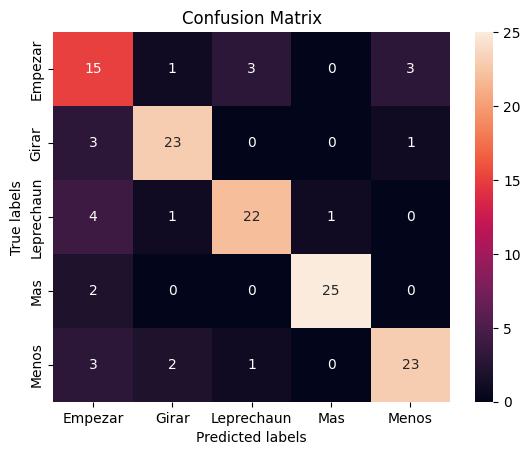

In [50]:
accuracy = accuracy_score(
            y_true    = y_test.ravel(),
            y_pred    = predictions.ravel(),
            normalize = True
           )

print("Confusion matrix")
print("-------------------")
T5_lables = ['Empezar','Girar','Leprechaun','Mas','Menos']

ax = plt.subplot()

cm = metrics.confusion_matrix(np.asarray(predictions), np.asarray(y_test))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);
print("")
print(f"The test accuracy is: {100 * accuracy} %")

num_correct = np.sum(y_test.ravel() == predictions)
print(f"The number of test data is: {len(y_test)}")
print(f"The number of correct predictions is: {num_correct}")

In [51]:
resultCR = metrics.classification_report(y_test, y_pred)
print("Classification Report:",)
print (resultCR)

clf.fit(x_train, y_train.ravel())
clf.fit(x_test, y_test.ravel())
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.56      0.61        27
           1       0.85      0.85      0.85        27
           2       0.79      0.85      0.81        26
           3       0.93      0.96      0.94        26
           4       0.79      0.85      0.82        27

    accuracy                           0.81       133
   macro avg       0.81      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133



# Save the model

---




In [52]:
joblib.dump(clf, "MyModel.joblib")

['MyModel.joblib']


# 🔥 Model Test
---




In [53]:
loaded_model = joblib.load("MyModel.joblib")

## Model testing with audios from the dataset

### Preprocessing and feature extraction for SINGLE AUDIO

In [54]:
def testAudio(signal):
    trimmed_signal = librosa.effects.trim(signal, top_db= 20)
    reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
    normalized_signal = librosa.util.normalize(reduced_noise_signal)

    melspec = librosa.feature.melspectrogram(y=normalized_signal, sr=fs, power=2, n_mels=n_mels_parameter, center=False, hop_length=hop_length_parameter, n_fft=n_fft_parameter)
    melspecM= np.mean(melspec.T, axis=0)

    mfcc = librosa.feature.mfcc(y =normalized_signal, n_mfcc=13)
    mfccM = np.mean(mfcc.T, axis=0)
    delta_mfcc = librosa.feature.delta(mfccM)
    delta2_mfcc = librosa.feature.delta(mfccM, order=2)

    chroma = librosa.feature.chroma_stft(y=normalized_signal, sr=fs)
    chromaM = np.mean(chroma.T, axis=0)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(normalized_signal), sr=fs)
    tonnetM = np.mean(tonnetz.T,axis=0)

    signal_features = np.hstack((mfccM, delta_mfcc, delta2_mfcc, melspecM, chromaM, tonnetM))

    return signal_features

### Loading a test audio and processing it





In [63]:
# Choose a folder among ["Empezar" == 0, "Girar" == 1, "Leprechaun" == 2, "Mas" == 3, "Menos" == 4]
folder_to_choose = "Girar"

pathFolder = f"/content/drive/MyDrive/SEÑALES/Audios Señales/{folder_to_choose}/{folder_to_choose}_123.wav"

rawAudio, s = librosa.load(path=pathFolder, sr=fs, mono=True)
test_signals = testAudio(rawAudio)
test_signals = np.reshape(test_signals,(1,97))

In [64]:
prediction = clf.predict(test_signals)
print(prediction)
predictionValue = clf.predict_proba(test_signals)
print(predictionValue)

[1]
[[0.07222222 0.72777778 0.08888889 0.02222222 0.08888889]]


## Testing the model with new audios

In [57]:
RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: {sampleSize: 16, channelCount: 1, sampleRate: 16000  }})
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

print(f"Hable máximo 2 segundos")
record(2,'audio.wav')

Hable máximo 2 segundos


<IPython.core.display.Javascript object>

In [58]:
# Read the audio file
audio_file = 'audio.wav'
audio_data = open(audio_file, 'rb').read()

# Play the audio
Audio(audio_data)

### Predict the new audio

In [66]:
rawAudioNew, s = librosa.load(path='audio.wav', sr=fs/2, mono=True)
test_signals_new = testAudio(rawAudioNew)
test_signals_new = np.reshape(test_signals_new,(1,97))
prediction_new = loaded_model.predict(test_signals_new)
print(prediction_new)
predictionValueNew = loaded_model.predict_proba(test_signals_new)
print(predictionValueNew)

[4]
[[0.19722222 0.23888889 0.06944444 0.14444444 0.35      ]]
